# DCTR $m_{jjj}$ Correlation Comparison

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function
from IPython.display import display, clear_output

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

import inspect

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Process Data

In [3]:
# Path to downloaded data from Zenodo
data_dir = '/data1/users/asuresh/DCTRFitting/TopQuarkFitting/'

### Define reweighting function

In [4]:
def reweight(default_dataset, mT):
    # DCTR architecture 
    inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

    outputs = Dense(2, activation='softmax')(hidden_layer_3)

    dctr = Model(inputs=inputs, outputs=outputs)
    dctr.compile(loss='categorical_crossentropy', optimizer='Adam')
    
    # Getting correct input format
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=(default_dataset.shape[0], 1)) * mT
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((default_dataset, concat_input_and_params),
                                 axis=-1)
    weights = K.zeros(shape=(default_dataset.shape[0], 0), dtype=tf.float32)
    
    # Getting weights from 240 different DCTRs
    for i in range(240):
        dctr.load_weights(
            data_dir +
            '/mjjj_DCTR_models/DCTR_1D_mT-mjjj-Trial{:n}.h5'.format(i))
        f = dctr(model_inputs)

        #     liklihood_ratio = len(X0)/len(X1)
        #     weights = liklihood_ratio*(f[:, 1]) / (f[:, 0])
        weights1 = (f[:, 1]) / (f[:, 0])
        weights1 = K.expand_dims(weights1, axis=1)
        weights = K.concatenate([weights, weights1])
    # Averaging weights over 240 runs
    weights = K.mean(weights, axis=1)
    return weights

In [5]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}
plot_style_1 = {'alpha': 0.5, 'density': True}

In [6]:
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'


def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

In [7]:
def plt_hist_to_cv(plt_histogram_output):
    counts, bin_edges, _ = plt_histogram_output
    return counts.ravel().astype('float32')

## Correlation over original sized datasets

In [8]:
test_dataset_0_obs = np.load(data_dir + 'part_172_5_6j_obs.npy')[:, :1]
test_dataset_1_obs = np.load(data_dir + 'part_175_0_6j_obs.npy')[:, :1]

test_dataset_0_obs_det = np.load(data_dir + 'det_172_5_6j_obs.npy')[:, :1]
test_dataset_1_obs_det = np.load(data_dir + 'det_175_0_6j_obs.npy')[:, :1]

print(np.shape(test_dataset_0_obs))
print(np.shape(test_dataset_1_obs))

(221723, 1)
(224595, 1)


theta:  170.0















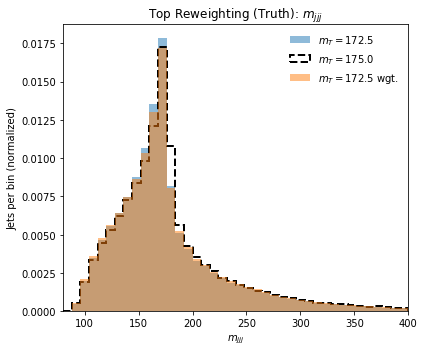

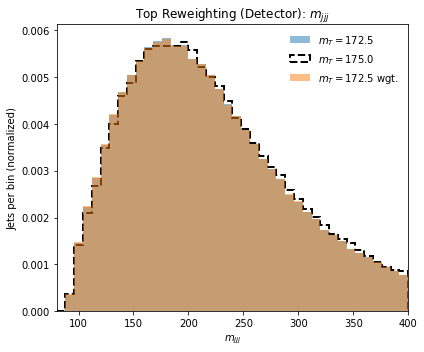

Truth Cor  0.9923724163739238
Det Cor  0.9988256040753305
theta:  170.5


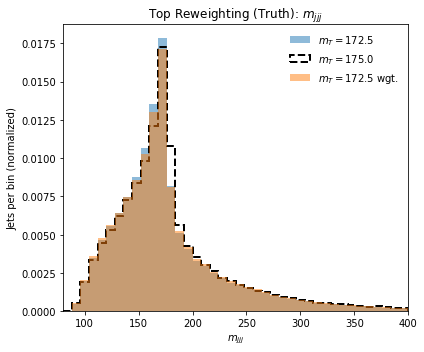

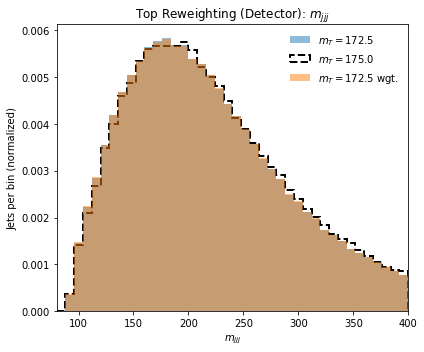

Truth Cor  0.9928389023810584
Det Cor  0.9988831637757403
theta:  171.0


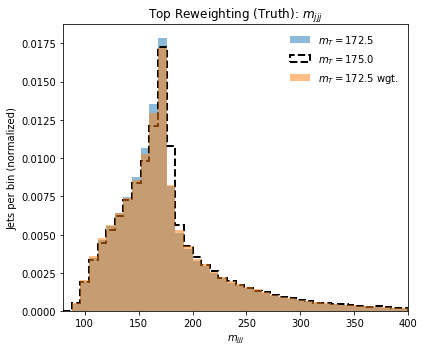

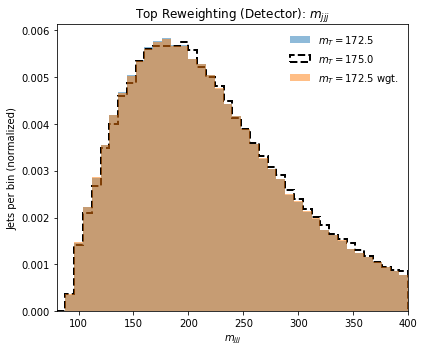

Truth Cor  0.9933376473536354
Det Cor  0.998941650283401
theta:  171.5


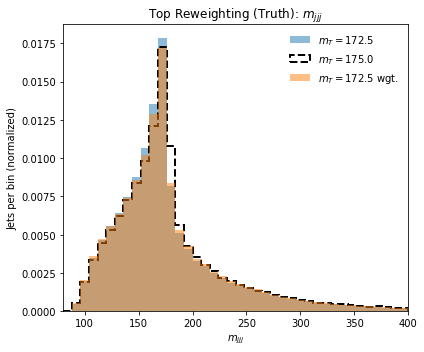

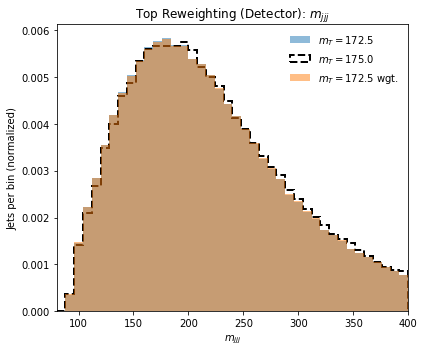

Truth Cor  0.9940077520199517
Det Cor  0.9990051439963741
theta:  172.0


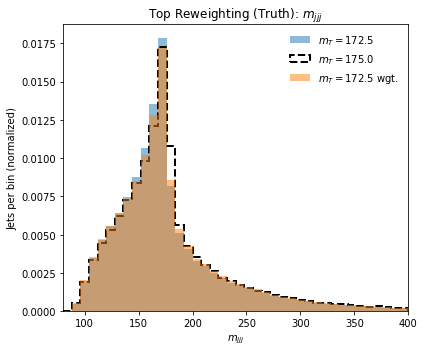

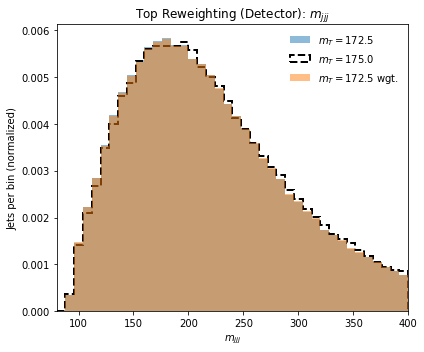

Truth Cor  0.994981339998458
Det Cor  0.9990736378117682
theta:  172.5


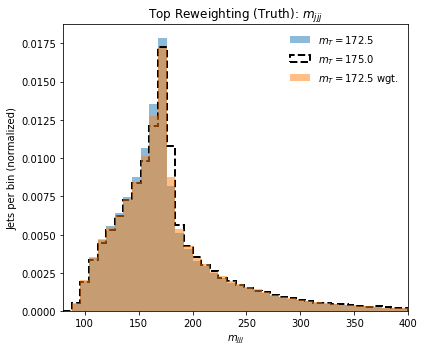

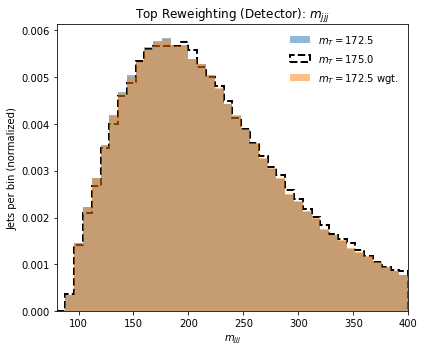

Truth Cor  0.9960299791539676
Det Cor  0.9991494701754406
theta:  173.0


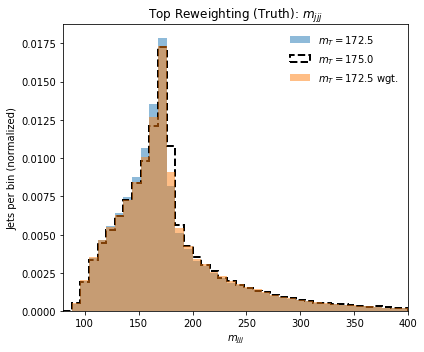

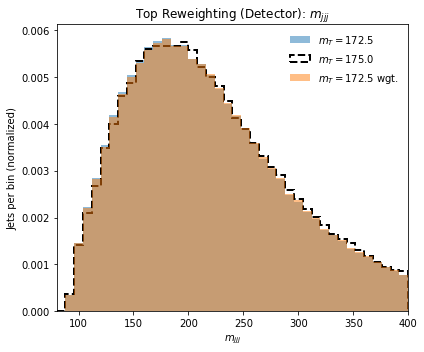

Truth Cor  0.9970560931301689
Det Cor  0.9992250246981849
theta:  173.5


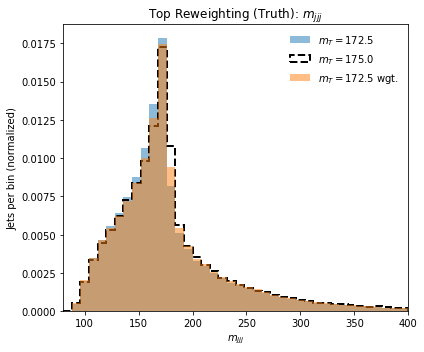

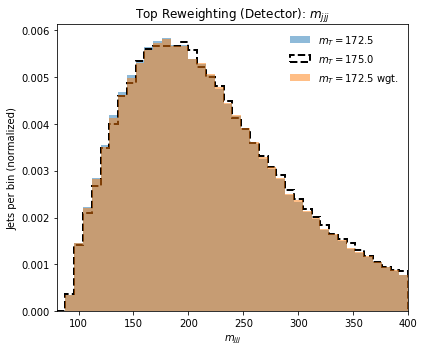

Truth Cor  0.9979889502433691
Det Cor  0.9992968918756011
theta:  174.0


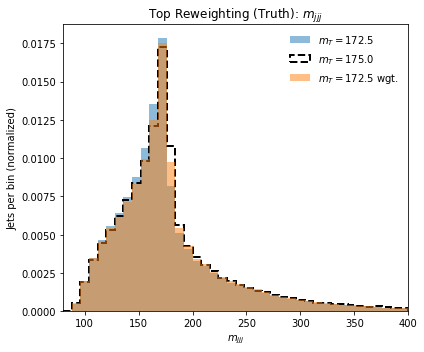

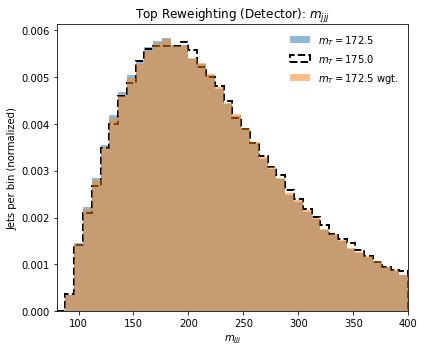

Truth Cor  0.9987868758911694
Det Cor  0.9993556585388179
theta:  174.5


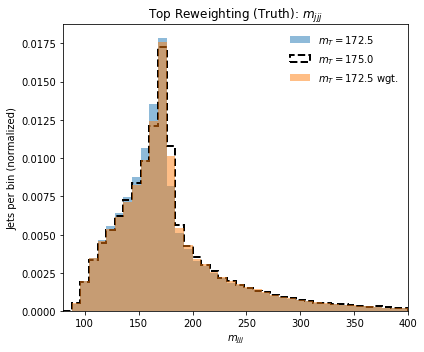

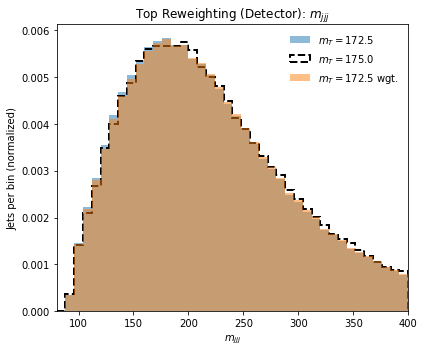

Truth Cor  0.9993899138443246
Det Cor  0.9994000287732026
theta:  175.0


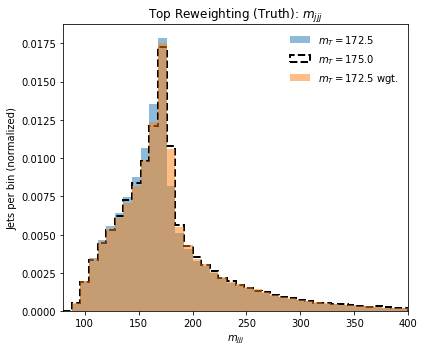

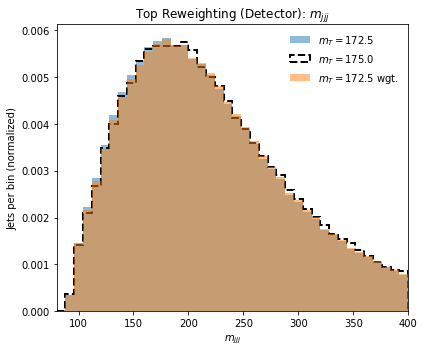

Truth Cor  0.9997218324888676
Det Cor  0.9994312188404731
theta:  175.5


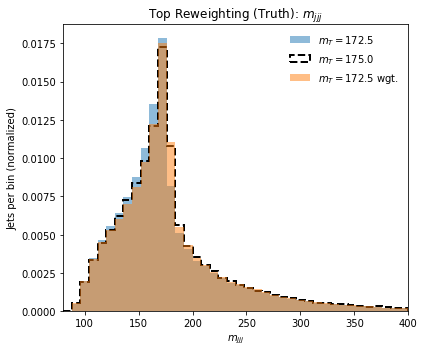

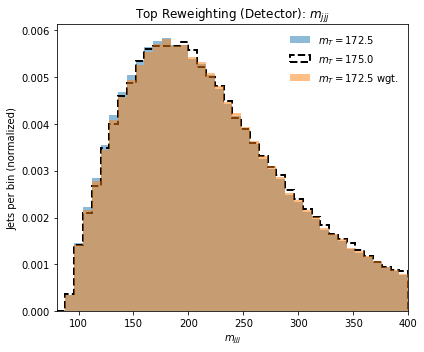

Truth Cor  0.9996821018107231
Det Cor  0.9994479250969672
theta:  176.0


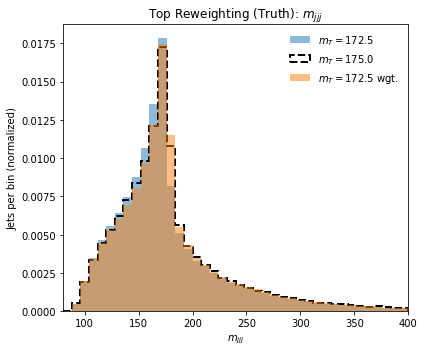

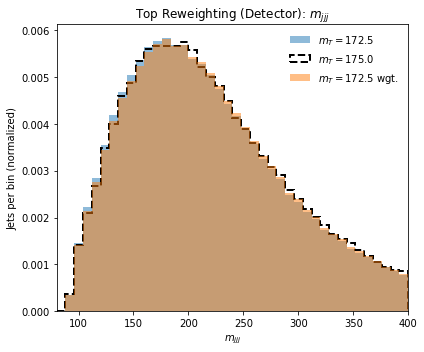

Truth Cor  0.9992374269298131
Det Cor  0.9994532628387198
theta:  176.5


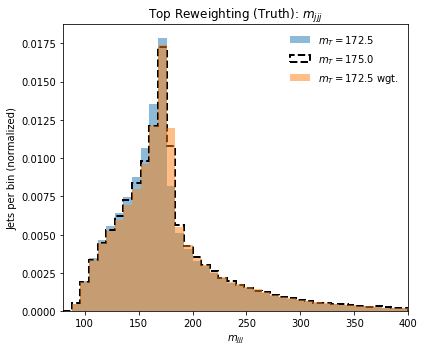

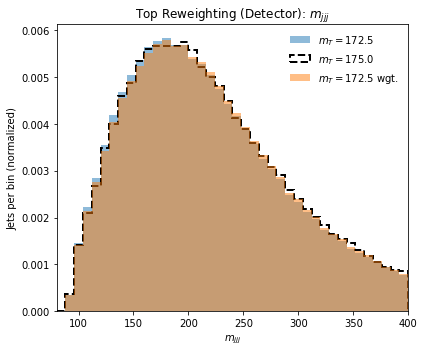

Truth Cor  0.9984611713149409
Det Cor  0.999446597952398
theta:  177.0


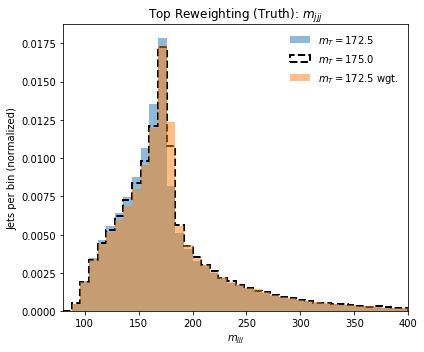

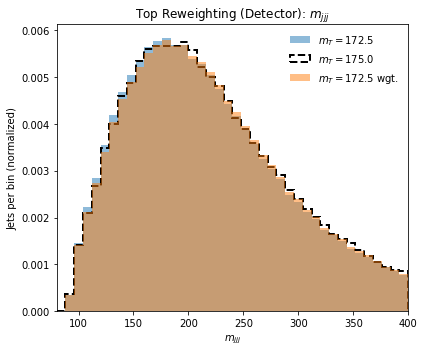

Truth Cor  0.9974484448709134
Det Cor  0.9994279119427764
theta:  177.5


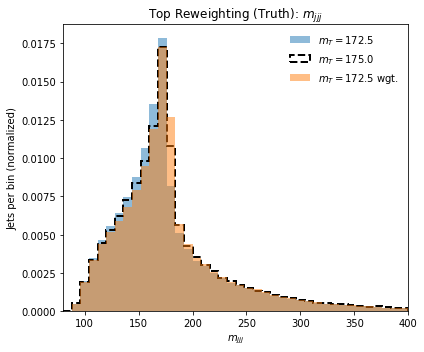

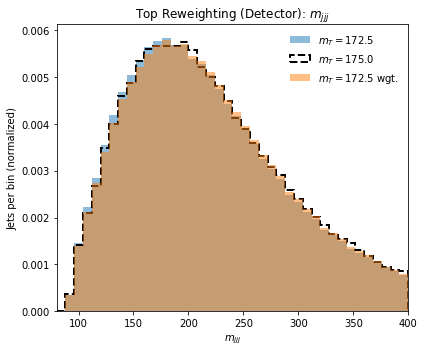

Truth Cor  0.9962998378139639
Det Cor  0.9993954358971572
theta:  178.0


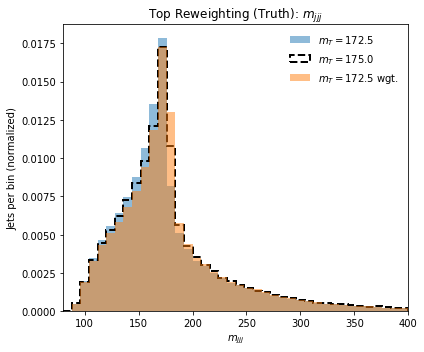

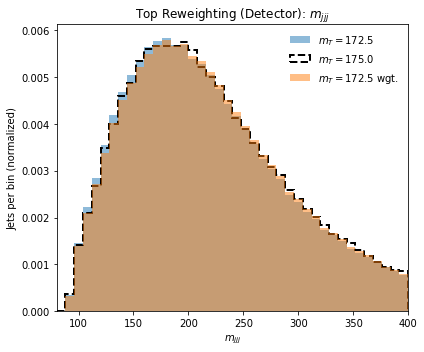

Truth Cor  0.9950914738631411
Det Cor  0.9993541015752532
theta:  178.5


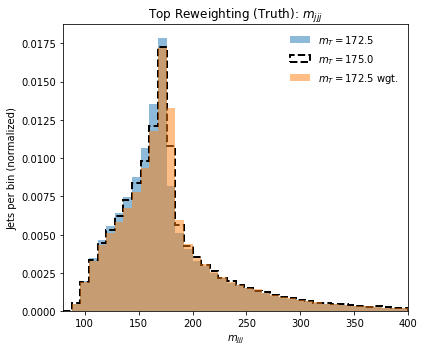

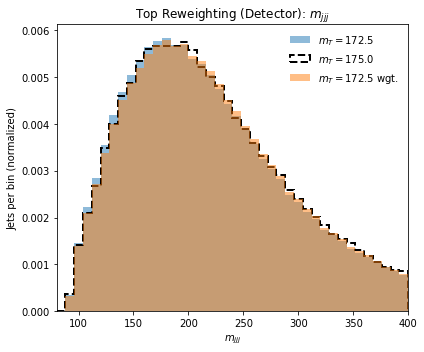

Truth Cor  0.9938715638694563
Det Cor  0.9992969684040769
theta:  179.0


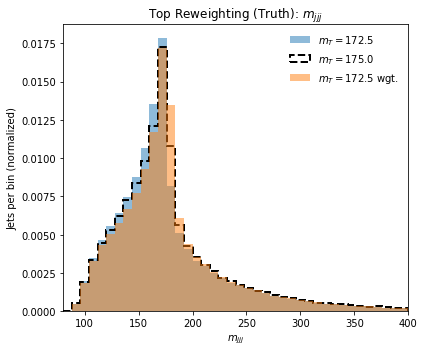

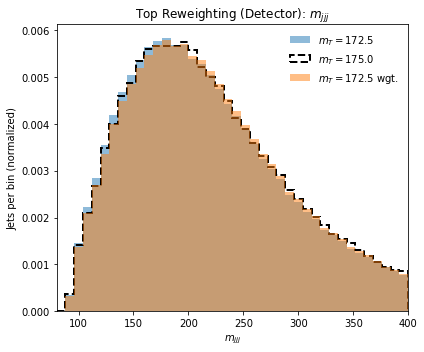

Truth Cor  0.9926725403606985
Det Cor  0.9992326256024823
theta:  179.5


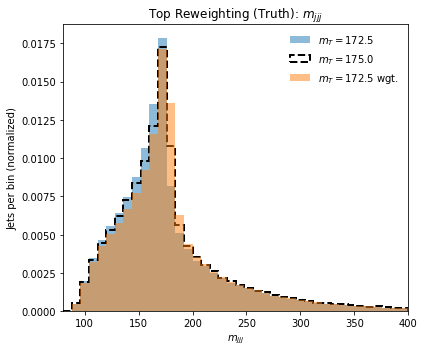

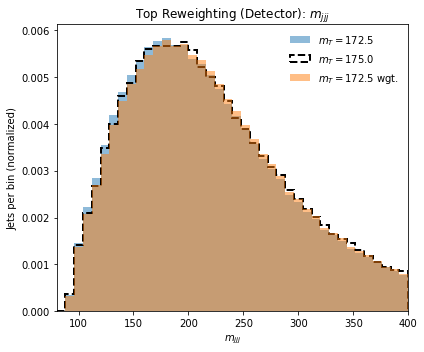

Truth Cor  0.9915048664078676
Det Cor  0.9991515668411899
theta:  180.0


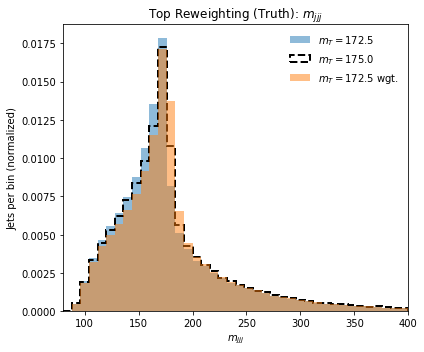

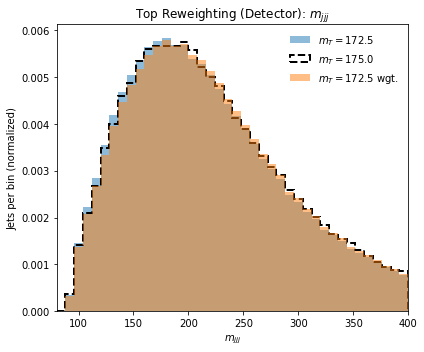

Truth Cor  0.9903759047759965
Det Cor  0.9990631705867877


In [9]:
thetas = np.linspace(170, 180, 21)
cor = []
cor_det = []
for theta in thetas:
    print("theta: ", theta)
    weights = reweight(default_dataset=tf.convert_to_tensor(
    (test_dataset_0_obs / 1000), dtype=tf.float32),
                     mT=(theta / 1000.))
    
    weights = K.eval(weights)
    K.clear_session()
    plt.figure(figsize=(6, 5))
    plt.title("Top Reweighting (Truth): $m_{jjj}$")
    bins = np.linspace(80, 400, 41)
    hist0_mjjj = plt.hist(test_dataset_0_obs[:, 0],
                          bins=bins,
                          label=label_0,
                          **plot_style_1)
    hist1_mjjj = plt.hist(test_dataset_1_obs[:, 0],
                          bins=bins,
                          label=label_1,
                          **plot_style_0)
    hist2_mjjj = plt.hist(test_dataset_0_obs[:, 0],
                          bins=bins,
                          label=label_0 + ' wgt.',
                          weights=weights,
                          **plot_style_1)
    plt.xlabel('$m_{jjj}$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80, 400])
    make_legend()
    plt.show()
    
    plt.figure(figsize=(6, 5))
    plt.title("Top Reweighting (Detector): $m_{jjj}$")
    bins = np.linspace(80, 400, 41)
    hist0_mjjj_det = plt.hist(test_dataset_0_obs_det[:, 0],
                          bins=bins,
                          label=label_0,
                          **plot_style_1)
    hist1_mjjj_det = plt.hist(test_dataset_1_obs_det[:, 0],
                          bins=bins,
                          label=label_1,
                          **plot_style_0)
    hist2_mjjj_det = plt.hist(test_dataset_0_obs_det[:, 0],
                          bins=bins,
                          label=label_0 + ' wgt.',
                          weights=weights,
                          **plot_style_1)
    plt.xlabel('$m_{jjj}$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80, 400])
    make_legend()
    plt.show()
    
    correlation = cv2.compareHist(plt_hist_to_cv(hist1_mjjj),
                          plt_hist_to_cv(hist2_mjjj),
                          method=0)
    cor += [correlation]
    print("Truth Cor ", correlation)
    
    correlation = cv2.compareHist(plt_hist_to_cv(hist1_mjjj_det),
                              plt_hist_to_cv(hist2_mjjj_det),
                              method=0)
    cor_det += [correlation]
    print("Det Cor ", correlation)

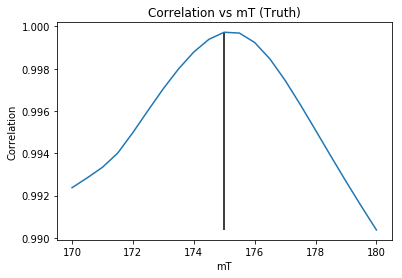

175.0


In [10]:
plt.title("Correlation vs mT (Truth)")
plt.xlabel("mT")
plt.ylabel("Correlation")
plt.plot(thetas, cor)
plt.vlines(175, min(cor), max(cor), label = 'Truth')
plt.legend
plt.show()

print(thetas[np.argmax(cor)])

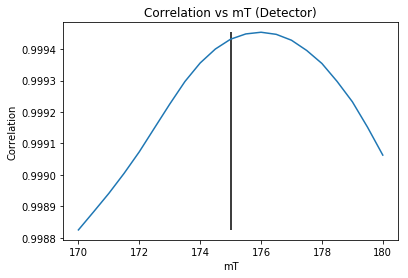

176.0


In [11]:
plt.title("Correlation vs mT (Detector)")
plt.xlabel("mT")
plt.ylabel("Correlation")
plt.plot(thetas, cor_det)
plt.vlines(175, min(cor_det), max(cor_det), label = 'Truth')
plt.legend
plt.show()

print(thetas[np.argmax(cor_det)])

## Correlation over x4 Datasets

In [12]:
test_dataset_0_obs_x4 = np.load(data_dir + 'part_172_5_6j_obs_x4.npy')[:, :1]
test_dataset_1_obs_x4 = np.load(data_dir + 'part_175_0_6j_obs_x4.npy')[:, :1]

test_dataset_0_obs_det_x4 = np.load(data_dir + 'det_172_5_6j_obs_x4.npy')[:, :1]
test_dataset_1_obs_det_x4 = np.load(data_dir + 'det_175_0_6j_obs_x4.npy')[:, :1]

print(np.shape(test_dataset_0_obs_x4))
print(np.shape(test_dataset_1_obs_x4))

(883443, 1)
(898044, 1)


theta:  170.0


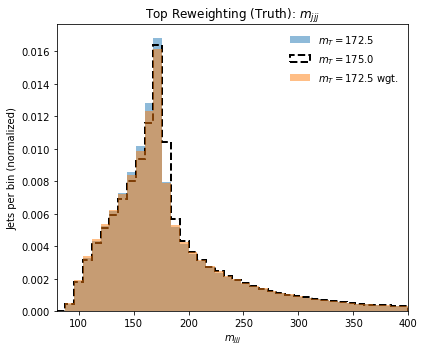

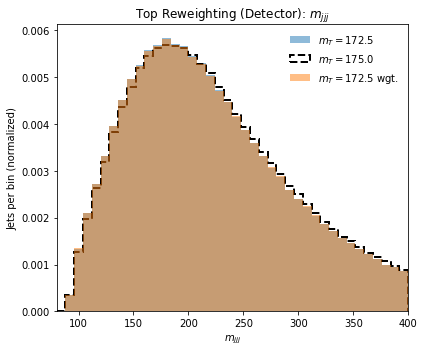

Truth Cor  0.9925095661228455
Det Cor  0.9990811557223183
theta:  170.5


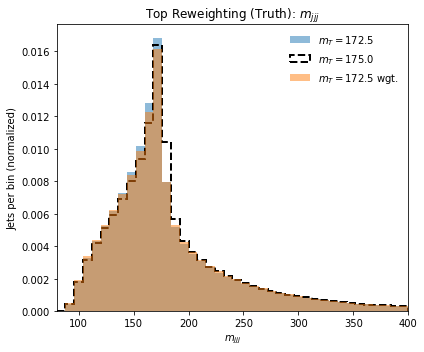

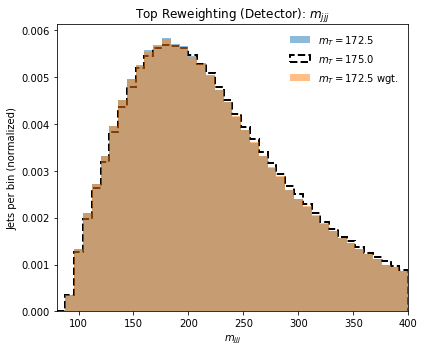

Truth Cor  0.9929916510564816
Det Cor  0.9991506638360811
theta:  171.0


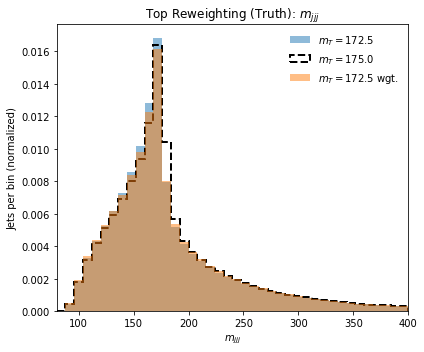

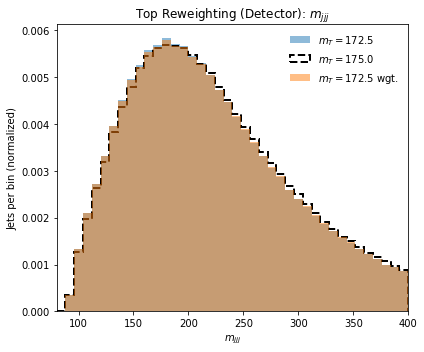

Truth Cor  0.9935077639493817
Det Cor  0.9992205122723472
theta:  171.5


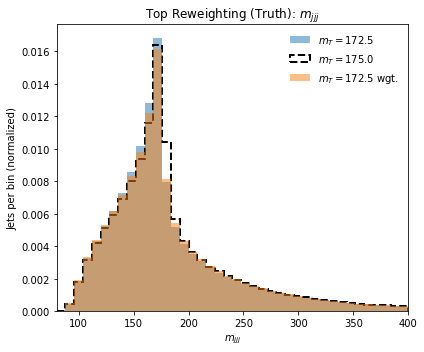

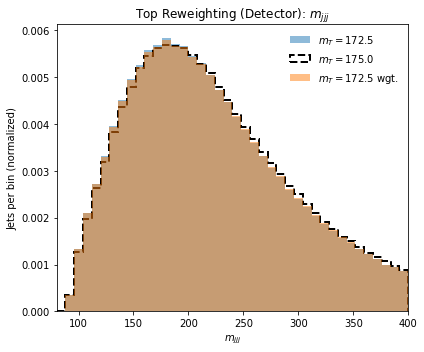

Truth Cor  0.9941975933273134
Det Cor  0.9992956755035106
theta:  172.0


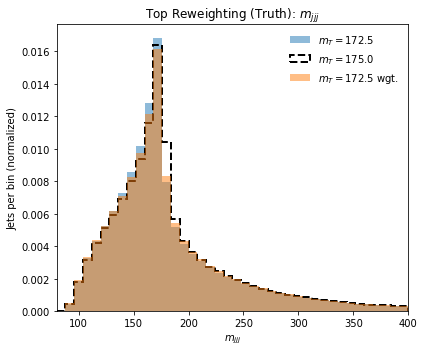

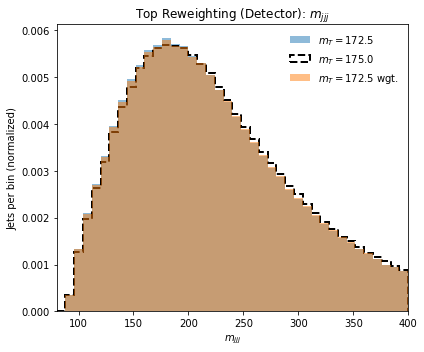

Truth Cor  0.9951931310744904
Det Cor  0.9993738568693277
theta:  172.5


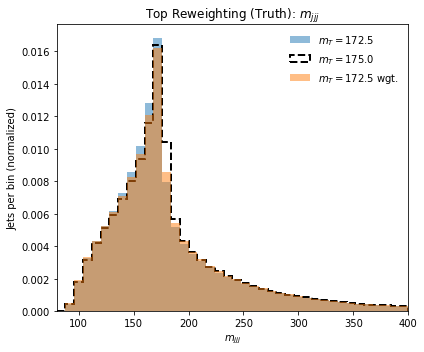

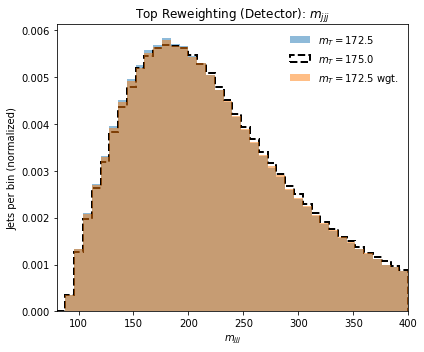

Truth Cor  0.9962707901848127
Det Cor  0.9994623451039839
theta:  173.0


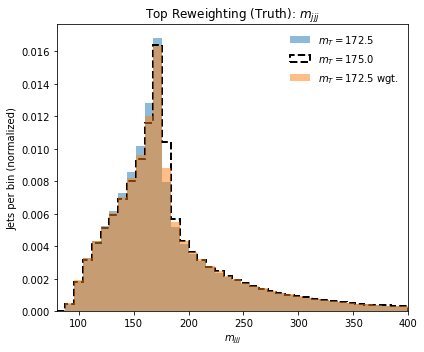

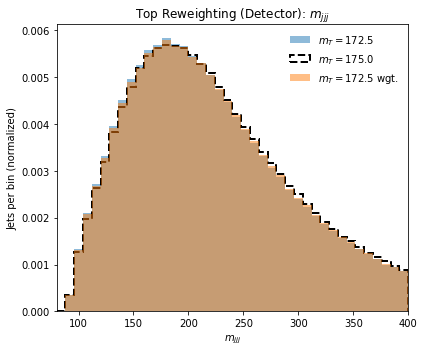

Truth Cor  0.9973310483842978
Det Cor  0.9995466853002559
theta:  173.5


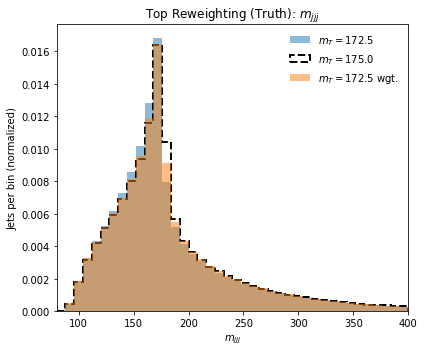

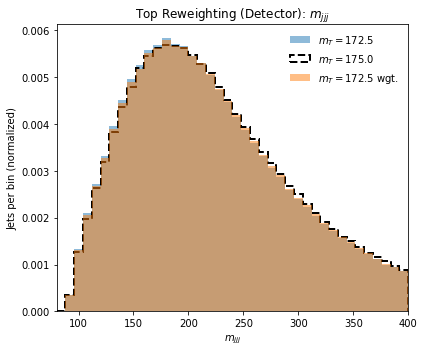

Truth Cor  0.9982870360653412
Det Cor  0.999627808885429
theta:  174.0


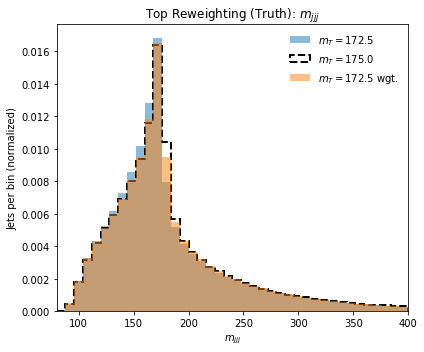

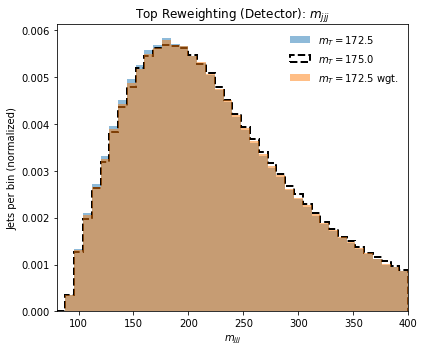

Truth Cor  0.9990823433578138
Det Cor  0.9996969029283344
theta:  174.5


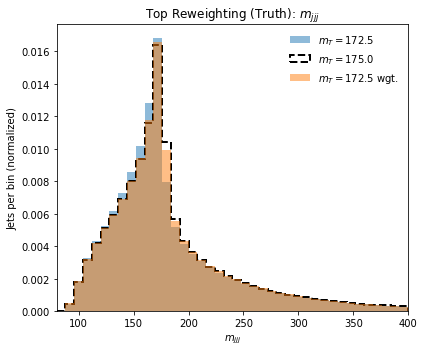

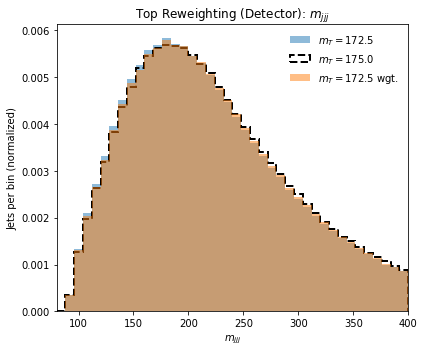

Truth Cor  0.9996551681165907
Det Cor  0.9997510613692594
theta:  175.0


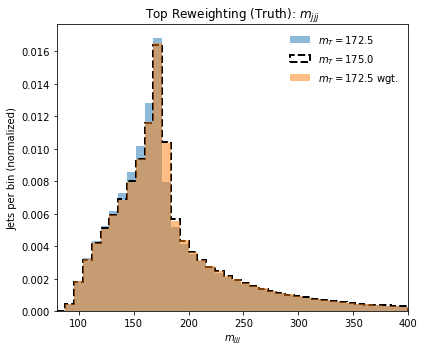

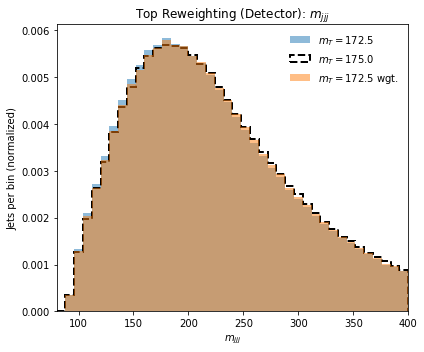

Truth Cor  0.9999192814429262
Det Cor  0.9997937806231498
theta:  175.5


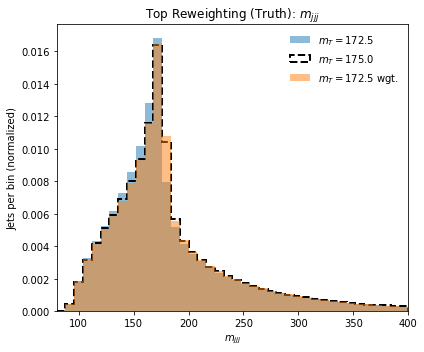

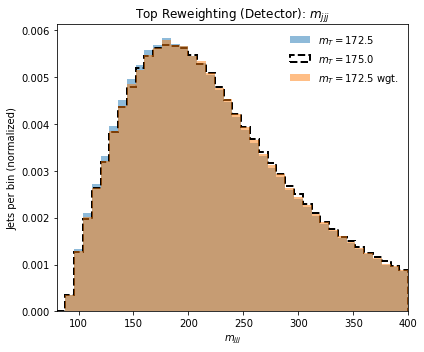

Truth Cor  0.9997764092806394
Det Cor  0.99982258096446
theta:  176.0


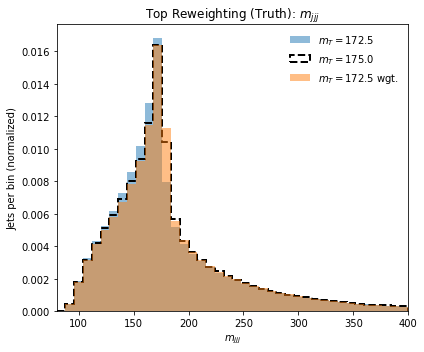

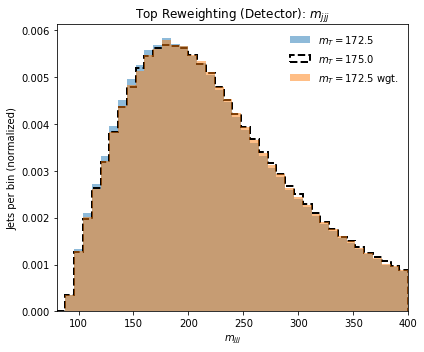

Truth Cor  0.999200323158855
Det Cor  0.9998394478918347
theta:  176.5


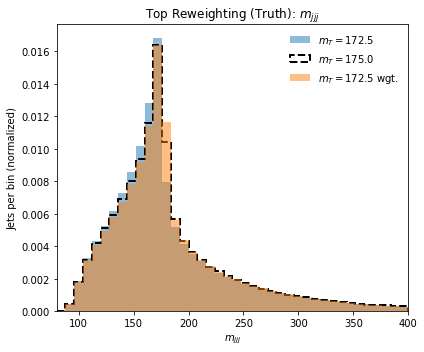

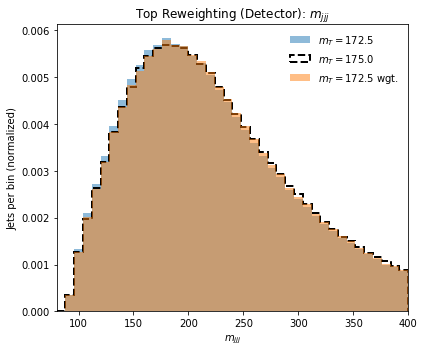

Truth Cor  0.998271107828294
Det Cor  0.9998444936694156
theta:  177.0


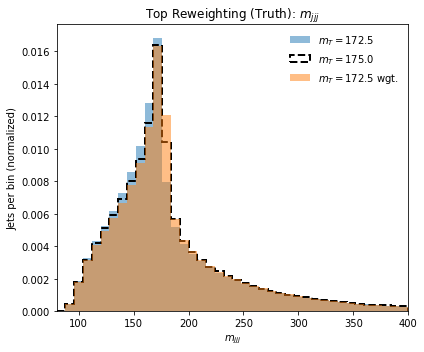

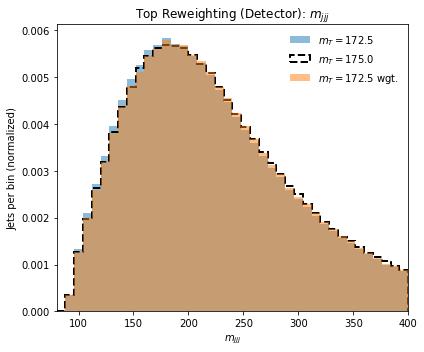

Truth Cor  0.9970943062717611
Det Cor  0.9998369863973207
theta:  177.5


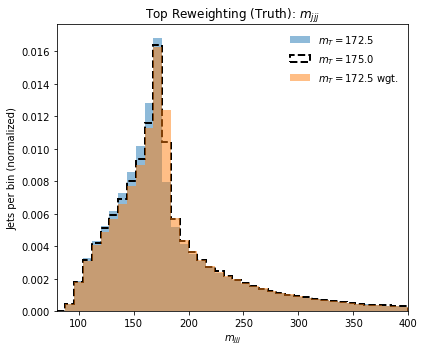

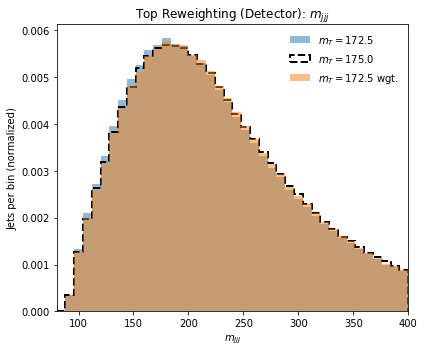

Truth Cor  0.9957816028536977
Det Cor  0.9998184790001188
theta:  178.0


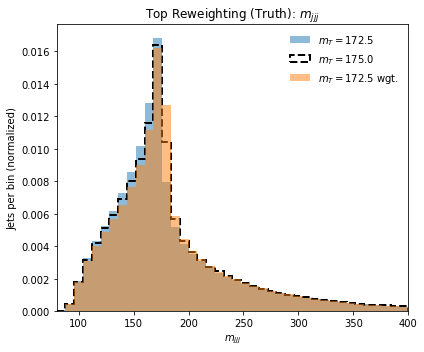

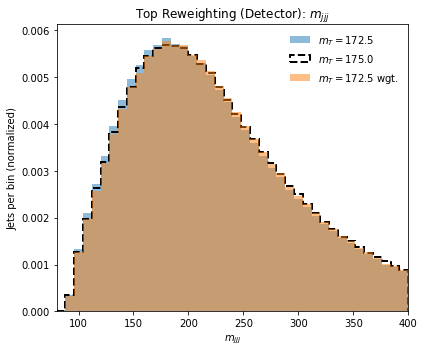

Truth Cor  0.9944211148111208
Det Cor  0.999789095116152
theta:  178.5


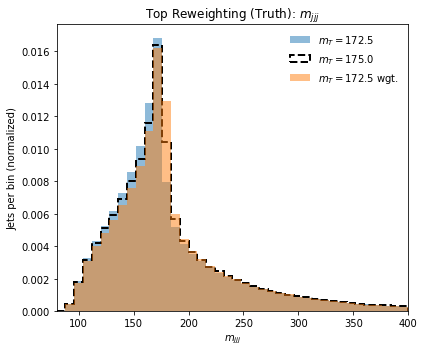

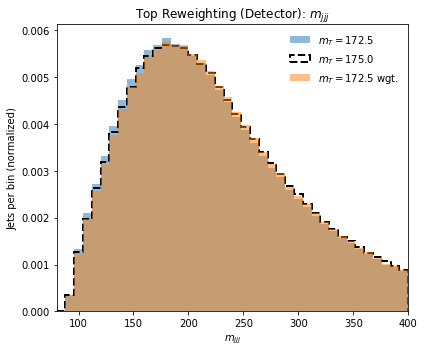

Truth Cor  0.9930535460954125
Det Cor  0.9997482398338128
theta:  179.0


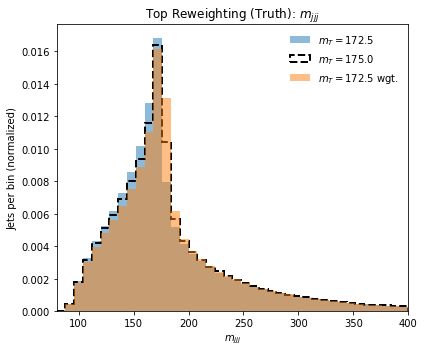

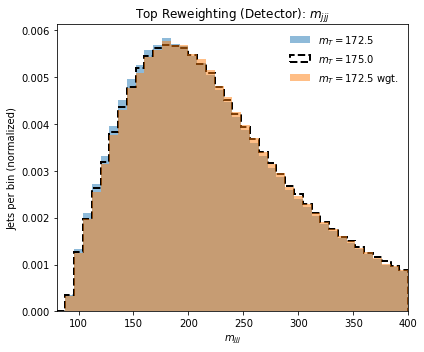

Truth Cor  0.9917113916373768
Det Cor  0.9996987635581802
theta:  179.5


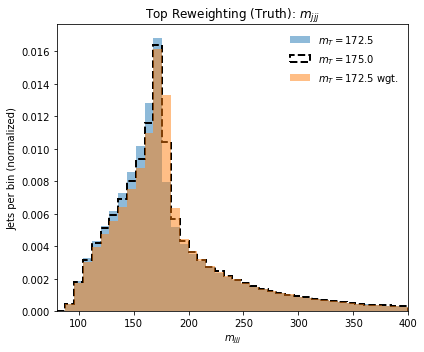

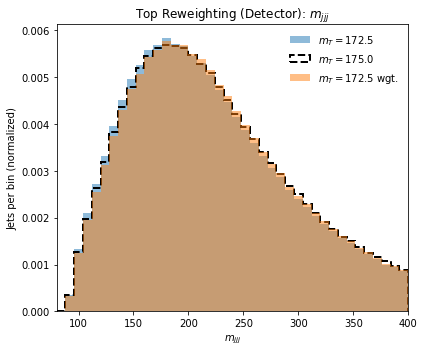

Truth Cor  0.9904039657569971
Det Cor  0.9996377196128683
theta:  180.0


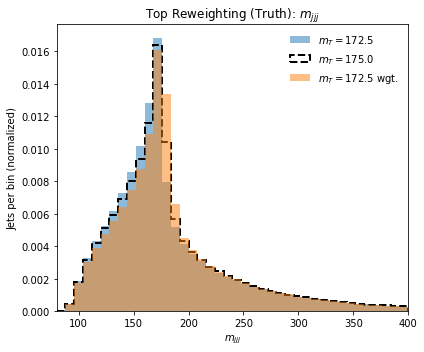

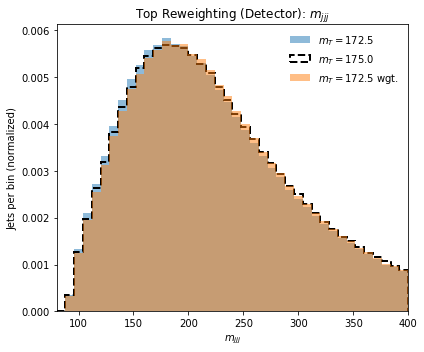

Truth Cor  0.9891354437001746
Det Cor  0.999568034064089


In [13]:
thetas = np.linspace(170, 180, 21)
cor_x4 = []
cor_det_x4= []
for theta in thetas:
    print("theta: ", theta)
    weights = reweight(default_dataset=tf.convert_to_tensor(
    (test_dataset_0_obs_x4 / 1000), dtype=tf.float32),
                     mT=(theta / 1000.))
    
    weights = K.eval(weights)
    K.clear_session()
    plt.figure(figsize=(6, 5))
    plt.title("Top Reweighting (Truth): $m_{jjj}$")
    bins = np.linspace(80, 400, 41)
    hist0_mjjj = plt.hist(test_dataset_0_obs_x4[:, 0],
                          bins=bins,
                          label=label_0,
                          **plot_style_1)
    hist1_mjjj = plt.hist(test_dataset_1_obs_x4[:, 0],
                          bins=bins,
                          label=label_1,
                          **plot_style_0)
    hist2_mjjj = plt.hist(test_dataset_0_obs_x4[:, 0],
                          bins=bins,
                          label=label_0 + ' wgt.',
                          weights=weights,
                          **plot_style_1)
    plt.xlabel('$m_{jjj}$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80, 400])
    make_legend()
    plt.show()
    
    plt.figure(figsize=(6, 5))
    plt.title("Top Reweighting (Detector): $m_{jjj}$")
    bins = np.linspace(80, 400, 41)
    hist0_mjjj_det = plt.hist(test_dataset_0_obs_det_x4[:, 0],
                          bins=bins,
                          label=label_0,
                          **plot_style_1)
    hist1_mjjj_det = plt.hist(test_dataset_1_obs_det_x4[:, 0],
                          bins=bins,
                          label=label_1,
                          **plot_style_0)
    hist2_mjjj_det = plt.hist(test_dataset_0_obs_det_x4[:, 0],
                          bins=bins,
                          label=label_0 + ' wgt.',
                          weights=weights,
                          **plot_style_1)
    plt.xlabel('$m_{jjj}$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80, 400])
    make_legend()
    plt.show()
    
    correlation = cv2.compareHist(plt_hist_to_cv(hist1_mjjj),
                          plt_hist_to_cv(hist2_mjjj),
                          method=0)
    cor_x4 += [correlation]
    print("Truth Cor ", correlation)
    
    correlation = cv2.compareHist(plt_hist_to_cv(hist1_mjjj_det),
                              plt_hist_to_cv(hist2_mjjj_det),
                              method=0)
    cor_det_x4 += [correlation]
    print("Det Cor ", correlation)

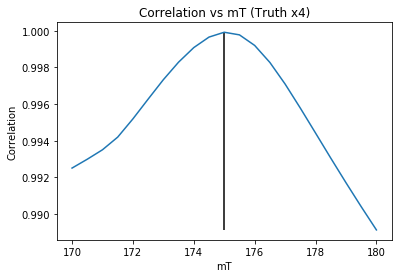

175.0


In [14]:
plt.title("Correlation vs mT (Truth x4)")
plt.xlabel("mT")
plt.ylabel("Correlation")
plt.plot(thetas, cor_x4)
plt.vlines(175, min(cor_x4), max(cor_x4), label = 'Truth')
plt.legend
plt.show()

print(thetas[np.argmax(cor_x4)])

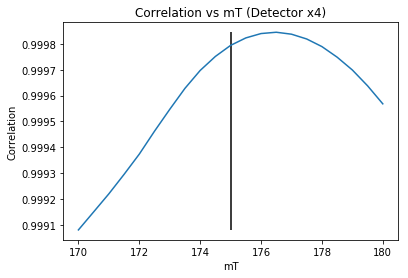

176.5


In [15]:
plt.title("Correlation vs mT (Detector x4)")
plt.xlabel("mT")
plt.ylabel("Correlation")
plt.plot(thetas, cor_det_x4)
plt.vlines(175, min(cor_det_x4), max(cor_det_x4), label = 'Truth')
plt.legend
plt.show()

print(thetas[np.argmax(cor_det_x4)])